## Project 3-6-3 Amazon Reviews

Use one of the following datasets to perform sentiment analysis on the given Amazon reviews. Pick one of the "small" datasets that is a reasonable size for your computer. The goal is to create a model to algorithmically predict if a review is positive or negative just based on its text. Try to see how these reviews compare across categories. Does a review classification model for one category work for another?

http://jmcauley.ucsd.edu/data/amazon/

In [23]:
import json
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC

In [2]:
jsonfile = 'reviews_Tools_and_Home_Improvement_5.json'

# read the entire file into a python array
with open(jsonfile, 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.decode("utf-8").rstrip('\n'), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
orig_data_df = pd.read_json(data_json_str)

In [3]:
orig_data_df['text'] = orig_data_df[['reviewText', 'summary']].apply(lambda x: ''.join(x), axis=1)

In [4]:
feature_text = 'summary'

X = orig_data_df[[feature_text, 'overall']]# data_df.loc[:, ~data_df.columns.isin(['asin', 'summary', 'reviewText', 'reviewerID', 'reviewerName', 'unixReviewTime', 'reviewTime', 'unixReviewTime', 'overall', 'target'])]
Y = orig_data_df['overall']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2 )

In [8]:
#resample data so that the labels are better represented
resample_perc = len(X_train[X_train.overall <4])/len(X_train[X_train.overall >=4])
df_resampled = X_train[X_train.overall>=4].sample(frac=resample_perc, replace=False)

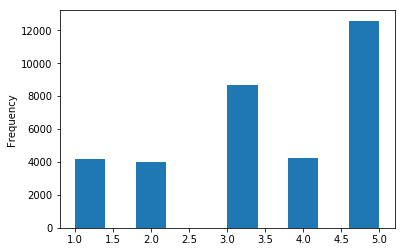

In [9]:
data_df = pd.concat([X_train[X_train.overall <4], df_resampled])
data_df.overall.plot.hist()

0.5

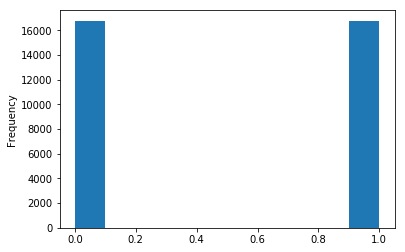

In [10]:
data_df['target'] = [1 if overall>=4 else 0 for overall in data_df.overall]

# check to see if classes in the training set are reasonably well represented
data_df['target'].plot.hist()
sum(data_df['target'])/len(data_df['target'])

In [27]:
len(X_train), len(y_train)

(33584, 33584)

In [11]:
X_train = data_df[feature_text]
y_train = data_df['target']

y_test = [1 if overall>=4 else 0 for overall in X_test.overall]
X_test = X_test[feature_text]

In [12]:
def get_wordcounts(text, vectorizer=None):
    """
    Takes a string or list of strings and returns term frequencies for each word in
    a vectorizer's vocabulary. If no vectorizer is passed, the vocabulary will be generated
    from the input text's unigrams and bigrams.
    """
    if vectorizer is None:
        vectorizer = CountVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
        vectorizer.fit(text)
    term_counts = zip(vectorizer.get_feature_names(),
        np.asarray(vectorizer.transform(text).sum(axis=0)).ravel())
    return sorted(term_counts, key=lambda x: x[1], reverse=True)

def get_tfidf_weights(text, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
        vectorizer.fit(text)
    tfidf_weights = zip(vectorizer.get_feature_names(),
        np.asarray(vectorizer.transform(text).sum(axis=0)).ravel())
    return sorted(tfidf_weights, key=lambda x: x[1], reverse=True)

In [13]:
amz_df_train = pd.DataFrame({'feature_text': X_train, 'target':y_train})

amz_df_pos = amz_df_train[(amz_df_train.target == 1)]
amz_df_neg = amz_df_train[(amz_df_train.target == 0)]

In [14]:
num_words = 60

def get_tfidf(text):
    tfidf_vec = TfidfVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
    tfidf_vec.fit(text)

    train_tfidf = get_tfidf_weights(text, tfidf_vec)[:num_words]
    return train_tfidf

def get_counts(text):
    count_vec = CountVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
    
    count_vec.fit(text)
    train_counts = get_wordcounts(text, count_vec)[:num_words]
    return train_counts

In [15]:
pos_words = [word_score[0] for word_score in get_tfidf(amz_df_pos['feature_text'])]
print(len(pos_words))
neg_words = [word_score[0] for word_score in get_tfidf(amz_df_neg['feature_text'])]
print(len(neg_words))
neg_words2 = [word_score[0] for word_score in get_counts(amz_df_neg['feature_text'])]
neg_words = list(set(neg_words + neg_words2))
print(len(neg_words))

pos_words = [word for word in pos_words if word not in neg_words]   
print(len(pos_words))

60
60
63
28


In [16]:
generic = ['drill', 'saw', 'flashlight', 'target','solid']
for word in generic:
    if word in pos_words:
        pos_words.remove(word)
        
d = {word:[] for word in pos_words}

for word in d.keys():
    d[word]= [1 if word in comment.lower() else 0 for comment in amz_df_train.feature_text]
        
df_train = pd.DataFrame(d)
df_train['target'] = amz_df_train.target
df_train = df_train.dropna()

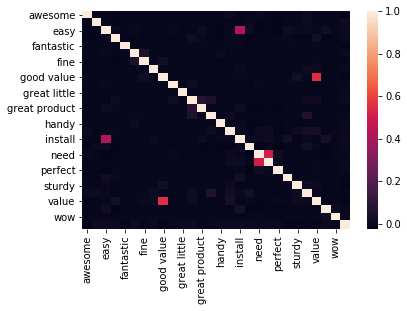

In [17]:
sns.heatmap(df_train.corr())

In [18]:
d = {word:[] for word in pos_words}
for word in d.keys():
    d[word]= [1 if word in comment.lower() else 0 for comment in X_test]
    
df_test = pd.DataFrame(d)
df_test['target'] = y_test

## Naive Bayes

In [19]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(df_train[pos_words], df_train.target)

y_pred = bnb.predict(df_test[pos_words])

print("Number of mislabeled points out of a total {} points : {}".format(
    df_test[pos_words].shape[0],
    (df_test.target != y_pred).sum()
))

Number of mislabeled points out of a total 26896 points : 5983


In [20]:
bnb.score(df_test[pos_words], df_test.target)

0.7775505651397977

In [21]:
# check to see if model guessed one class for the whole test set
sum(y_pred)/len(y_pred)

0.92002528256989891

## SVM-C

In [262]:
params_svc = {'C':[.8, .9, 1.0], 
              'kernel':['linear', 'poly', 'rbf'], 
              'degree':[2,3,4], 
              'gamma':['auto_deprecated'], 
              'coef0':[0.0, .2], 
              'shrinking':[False, True], 
              'probability':[False], 
              'tol':[0.001], 
              'cache_size':[200],  
              'verbose':[False], 
              'max_iter':[-1], 
              'decision_function_shape':['ovr'], 
              'random_state':[3]}

svc = SVC()
svm_gs = GridSearchCV(svc, params_svc, cv=5, n_jobs=-1)
svm_gs.fit(df_train[pos_words], df_train.target)

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.8, 0.9, 1.0], 'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3, 4], 'gamma': ['auto_deprecated'], 'coef0': [0.0, 0.2], 'shrinking': [False, True], 'probability': [False], 'tol': [0.001], 'cache_size': [200], 'verbose': [False], 'max_iter': [-1], 'decision_function_shape': ['ovr'], 'random_state': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [263]:
preds = svm_gs.predict(df_test[pos_words])

In [264]:
svm_gs.score(df_test[pos_words], y_test)

0.84436347412254609

In [242]:
# check to see if model guessed one class for the whole test set
sum(preds)/len(preds)

0.9953896490184414

In [28]:
svc = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
svc.fit(df_train[pos_words], df_train.target)

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [29]:
predict_train = svc.predict(df_train[pos_words])
predict_test = svc.predict(df_test[pos_words])

# Accuracy tables.
table_train = pd.crosstab(df_train.target, predict_train, margins=True)
table_test = pd.crosstab(df_test.target, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))



Training set accuracy:
Percent Type I errors: 0.4936216741586684
Percent Type II errors: 0.0010934272870854087

Test set accuracy:
Percent Type I errors: 0.1515466983938132
Percent Type II errors: 0.004387269482450922


In [30]:
svc.score(df_test[pos_words], y_test)

0.84406603212373588

In [31]:
jsonfile = 'reviews_Home_and_Kitchen_5.json'

import pandas as pd

# read the entire file into a python array
with open(jsonfile, 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.decode("utf-8").rstrip('\n'), data)

data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
test_data_df = pd.read_json(data_json_str)


feature_text = 'summary'

X2 = test_data_df[feature_text]# data_df.loc[:, ~data_df.columns.isin(['asin', 'summary', 'reviewText', 'reviewerID', 'reviewerName', 'unixReviewTime', 'reviewTime', 'unixReviewTime', 'overall', 'target'])]
Y2 = [1 if overall>=4 else 0 for overall in test_data_df.overall]

d2 = {word:[] for word in pos_words}
for word in d2.keys():
    d2[word]= [1 if word in comment.lower() else 0 for comment in X2]
    
X_test2 = pd.DataFrame(d2)
y_test2 = Y2

In [33]:
svc.score(X_test2[pos_words], y_test2)

0.82227805148618227

In [34]:
bnb.score(X_test2[pos_words], y_test2)

0.7676723184733234